<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/student/W2D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 5, Tutorial 1
# Learning to Predict

__Content creators:__ Marcelo Mattar with help from Matt Krause

__Content reviewers:__ Byron Galbraith and Michael Waskom


---

# Tutorial objectives
  
In this tutorial, we will learn how to estimate state-value functions in a classical conditioning paradigm using Temporal Difference (TD) learning and examine TD-errors at the presentation of the conditioned and unconditioned stimulus (CS and US) under different CS-US contingencies. These exercises will provide you with an understanding of both how reward prediction errors (RPEs) behave in classical conditioning and what we should expect if Dopamine represents a "canonical" model-free RPE.
    
* You will learn to use the standard tapped delay line conditioning model
* You will understand how RPEs move to CS
* You will understand how variability in reward size effects RPEs
* You will understand how differences in US-CS timing effect RPEs

In [1]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt

In [2]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [3]:
# @title Helper functions
def plot_value_function(V, ax=None, show=True):
  """Plot V(s), the value function"""
  if not ax:
    fig, ax = plt.subplots()

  ax.stem(V, use_line_collection=True)
  ax.set_ylabel('Value')
  ax.set_xlabel('State')
  ax.set_title("Value function: $V(s)$")
  
  if show:
    plt.show()

def plot_tde_trace(TDE, ax=None, show=True, skip=400):
  """Plot the TD Error across trials"""
  if not ax:
    fig, ax = plt.subplots()

  indx = np.arange(0, TDE.shape[1], skip)
  im = ax.imshow(TDE[:,indx])
  ax.set_title('TD-error over learning')
  ax.set_ylabel('State')
  ax.set_xlabel('Iterations')
  ax.set_xticklabels([f"{int(skip * x)}" for x in ax.get_xticks()])
  ax.figure.colorbar(im)
  if show:
    plt.show()

def learning_summary_plot(V, TDE):
  """Summary plot for Ex1"""
  fig, (ax1, ax2) = plt.subplots(nrows = 2, gridspec_kw={'height_ratios': [1, 2]})
  
  plot_value_function(V, ax=ax1, show=False)
  plot_tde_trace(TDE, ax=ax2, show=False)
  plt.tight_layout()

def reward_guesser_title_hint(r1, r2):
  """"Provide a mildly obfuscated hint for a demo."""
  if (r1==14 and r2==6) or (r1==6 and r2==14):
    return "Technically correct...."
  
  if not (((r1+r2) & 5) & 7) - 4: # Don't spoil the fun :-)
    return "Congratulations! You solved it!"

  return "Keep trying...."

#@title Default title text
class ClassicalConditioning:
    
    def __init__(self, n_steps, reward_magnitude, reward_time):
        
        # Task variables
        self.n_steps = n_steps 
        self.n_actions = 0
        self.cs_time = int(n_steps/4) - 1

        # Reward variables
        self.reward_state = [0,0]
        self.reward_magnitude = None
        self.reward_probability = None
        self.reward_time = None
        
        self.set_reward(reward_magnitude, reward_time)
        
        # Time step at which the conditioned stimulus is presented

        # Create a state dictionary
        self._create_state_dictionary()
    
    def set_reward(self, reward_magnitude, reward_time):
        
        """
        Determine reward state and magnitude of reward
        """
        if reward_time >= self.n_steps - self.cs_time:
            self.reward_magnitude = 0
        
        else:
            self.reward_magnitude = reward_magnitude
            self.reward_state = [1, reward_time]
            
    def get_outcome(self, current_state):
    
        """
        Determine next state and reward
        """
        # Update state
        if current_state < self.n_steps - 1: 
            next_state = current_state + 1
        else:
            next_state = 0
            
        # Check for reward
        if self.reward_state == self.state_dict[current_state]:
            reward = self.reward_magnitude
        else:
            reward = 0
        
        return next_state, reward
    
    def _create_state_dictionary(self):
        
        """
        This dictionary maps number of time steps/ state identities
        in each episode to some useful state attributes:
        
        state      - 0 1 2 3 4 5 (cs) 6 7 8 9 10 11 12 ...
        is_delay   - 0 0 0 0 0 0 (cs) 1 1 1 1  1  1  1 ...
        t_in_delay - 0 0 0 0 0 0 (cs) 1 2 3 4  5  6  7 ...
        """
        d = 0

        self.state_dict = {}
        for s in range(self.n_steps):
            if s <= self.cs_time:
                self.state_dict[s] = [0,0]
            else: 
                d += 1 # Time in delay           
                self.state_dict[s] = [1,d]
  
class MultiRewardCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that one randomly selected reward, 
    magnitude, from a list, is delivered of a single fixed reward."""
  def __init__(self, n_steps, reward_magnitudes, reward_time=None):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: LIST of possible reward magnitudes.
        - reward_time: Single fixed reward time
      Uses numpy global random state.
      """
    super().__init__(n_steps, 1, reward_time)
    self.reward_magnitudes = reward_magnitudes
  
  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward=np.random.choice(self.reward_magnitudes)
    return next_state, reward
  

class ProbabilisticCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that rewards are stochastically omitted."""
  def __init__(self, n_steps, reward_magnitude, reward_time=None, p_reward=0.75):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: Reward magnitudes.
        - reward_time: Single fixed reward time.
        - p_reward: probability that reward is actually delivered in rewarding state
      Uses numpy global random state.
      """
    super().__init__(n_steps, reward_magnitude, reward_time)
    self.p_reward = p_reward
  
  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward*= int(np.random.uniform(size=1)[0] < self.p_reward)
    return next_state, reward


---
# Section 1: TD-learning

In [4]:
#@ title Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


__Environment:__

- The agent experiences the environment in episodes or trials. 
- Episodes terminate by transitioning to the inter-trial-interval (ITI) state and they are initiated from the ITI state as well. We clamp the value of the terminal/ITI states to zero. 
- The classical conditioning environment is composed of a sequence of states that the agent deterministically transitions through. Starting at State 0, the agent moves to State 1 in the first step, from State 1 to State 2 in the second, and so on.  These states represent time in the tapped delay line representation
- Within each episode, the agent is presented a CS and US (reward). 
- For each exercise, we use a different CS-US contingency. 
- The agent's goal is to learn to predict expected rewards from each state in the trial. 


__Definitions:__

1. Returns: 
\begin{align}
G_{t} = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ... = \sum \limits_{k = 1}^{\infty} \gamma^{k-1} r_{t+k}
\end{align}

2. Value: 
\begin{align}
V(s_{t}) = \mathbb{E} [ G_{t} | s_{t}] = \mathbb{E} [r_{t+1} + \gamma V_{t+1} | s_{t}] 
\end{align}

3. TD-error:
\begin{align}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{align}

4. Value updates:
\begin{align}
V(s_{t}) \leftarrow V(s_{t}) + \alpha \delta_{t}
\end{align}


## Exercise 1: TD-learning with guaranteed rewards
   
Implement TD-learning to estimate the state-value function in the classical-conditioning world with guaranteed rewards, with a fixed magnitude, at a fixed delay after the CS. Save TD-errors over learning so we can visualize them -- you're going to need to compute them anyway. 

Use the provided code to estimate the value function.

In [5]:
def td_learner(env, n_trials, gamma=0.98, alpha=0.001):
  """ Temporal Difference learning

  Args:
    env (object): the environment to be learned
    n_trials (int): the number of trials to run
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """
  V = np.zeros(env.n_steps) # Array to store values over states (time)
  TDE = np.zeros((env.n_steps, n_trials)) # Array to store TD errors

  for n in range(n_trials):
    state = 0 # Initial state
    for t in range(env.n_steps):
      # Get next state and next reward
      next_state, reward = env.get_outcome(state)
      # Is the current state in the delay period (after CS)?
      is_delay = env.state_dict[state][0]
      
      ########################################################################
      ## TODO for students: implement TD error and value function update    
      # Fill out function and remove
      raise NotImplementedError("Student excercise: implement TD error and value function update")
      #################################################################################
      # Write an expression to compute the TD-error
      TDE[state, n] = ...

      # Write an expression to update the value function
      V[state] += ...

      # Update state
      state = next_state

  return V, TDE


# Uncomment once the td_learner function is complete
# env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)
# V, TDE = td_learner(env, n_trials=20000)
# learning_summary_plot(V, TDE)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial1_Solution_0d9c50de.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial1_Solution_0d9c50de_1.png>



## Interactive Demo: US to CS Transfer 

During classical conditioning, the subject's behavioral response (e.g., salivating) transfers from the unconditioned stimulus (US) (e.g., the smell of tasty food) to the conditioned stimulus (CS) that predicts it. Reward prediction errors play an important role in this process by adjusting the value of states according to their expected, discounted return.

Use the widget below to examine how reward prediction errors change over time. Before training (red line), only the reward state has high reward prediction error. As training progresses (blue, slider), the reward prediction errors shift to the conditioned stimulus, where they end up when the trial is complete (green). 

Dopamine neurons, which are thought to carry reward prediction errors _in vivo_, show exactly the same behavior!


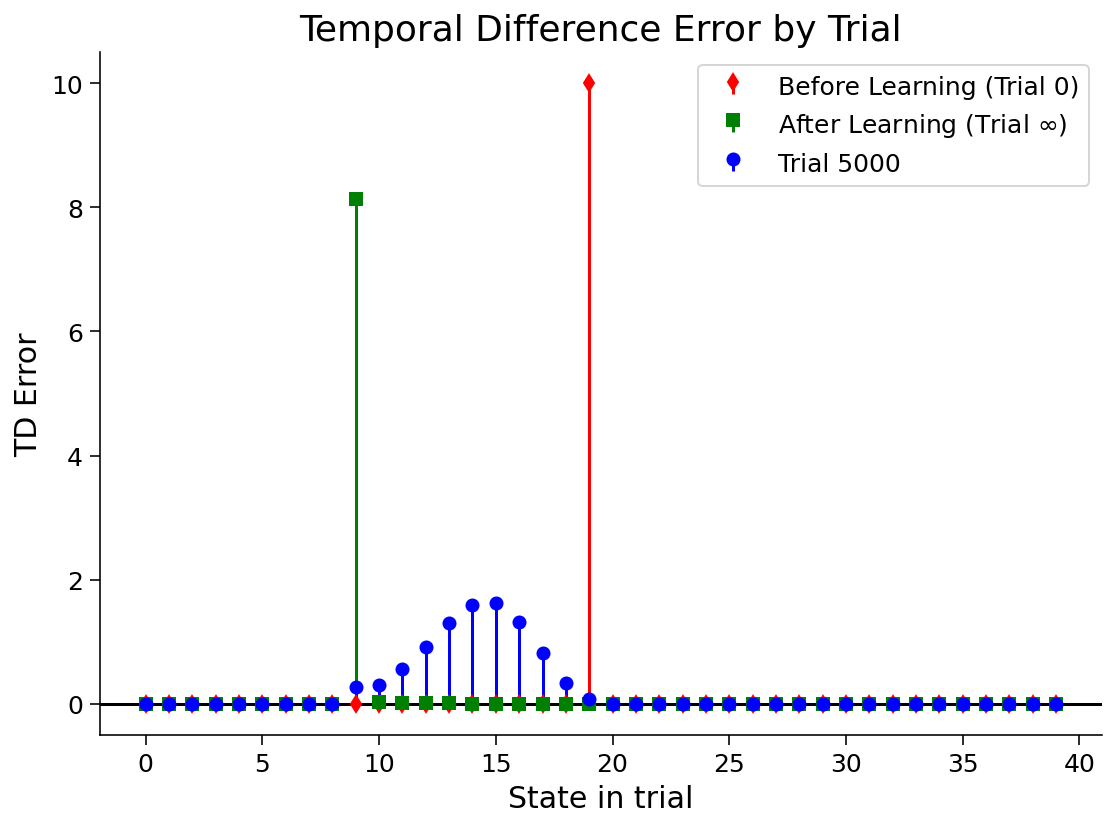

In [7]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!

n_trials = 20000

@widgets.interact
def plot_tde_by_trial(trial = widgets.IntSlider(value=5000, min=0, max=n_trials-1 , step=1, description="Trial #")):
  if 'TDE' not in globals():
    print("Complete Exercise 1 to enable this interactive demo!")
  else:

    fig, ax = plt.subplots()
    ax.axhline(0, color='k') # Use this + basefmt=' ' to keep the legend clean.
    ax.stem(TDE[:, 0], linefmt='r-', markerfmt='rd', basefmt=' ', 
            label="Before Learning (Trial 0)",
            use_line_collection=True)
    ax.stem(TDE[:, -1], linefmt='g-', markerfmt='gs', basefmt=' ', 
            label="After Learning (Trial $\infty$)",
            use_line_collection=True)
    ax.stem(TDE[:, trial], linefmt='b-', markerfmt='bo', basefmt=' ', 
            label=f"Trial {trial}",
            use_line_collection=True)
    
    ax.set_xlabel("State in trial")
    ax.set_ylabel("TD Error")
    ax.set_title("Temporal Difference Error by Trial")
    ax.legend()

## Interactive Demo: Learning Rates and Discount Factors

Our TD-learning agent has two parameters that control how it learns: $\alpha$, the learning rate, and $\gamma$, the discount factor. In Exercise 1, we set these parameters to $\alpha=0.001$ and $\gamma=0.98$ for you. Here, you'll investigate how changing these parameters alters the model that TD-learning learns.

Before enabling the interactive demo below, take a moment to think about the functions of these two parameters. $\alpha$ controls the size of the Value function updates produced by each TD-error. In our simple, deterministic world, will this affect the final model we learn? Is a larger $\alpha$ necessarily better in more complex, realistic environments?

The discount rate $\gamma$ applies an exponentially-decaying weight to returns occuring in the future, rather than the present timestep. How does this affect the model we learn? What happens when $\gamma=0$ or $\gamma \geq 1$?




/opt/hostedtoolcache/Python/3.7.8/x64/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


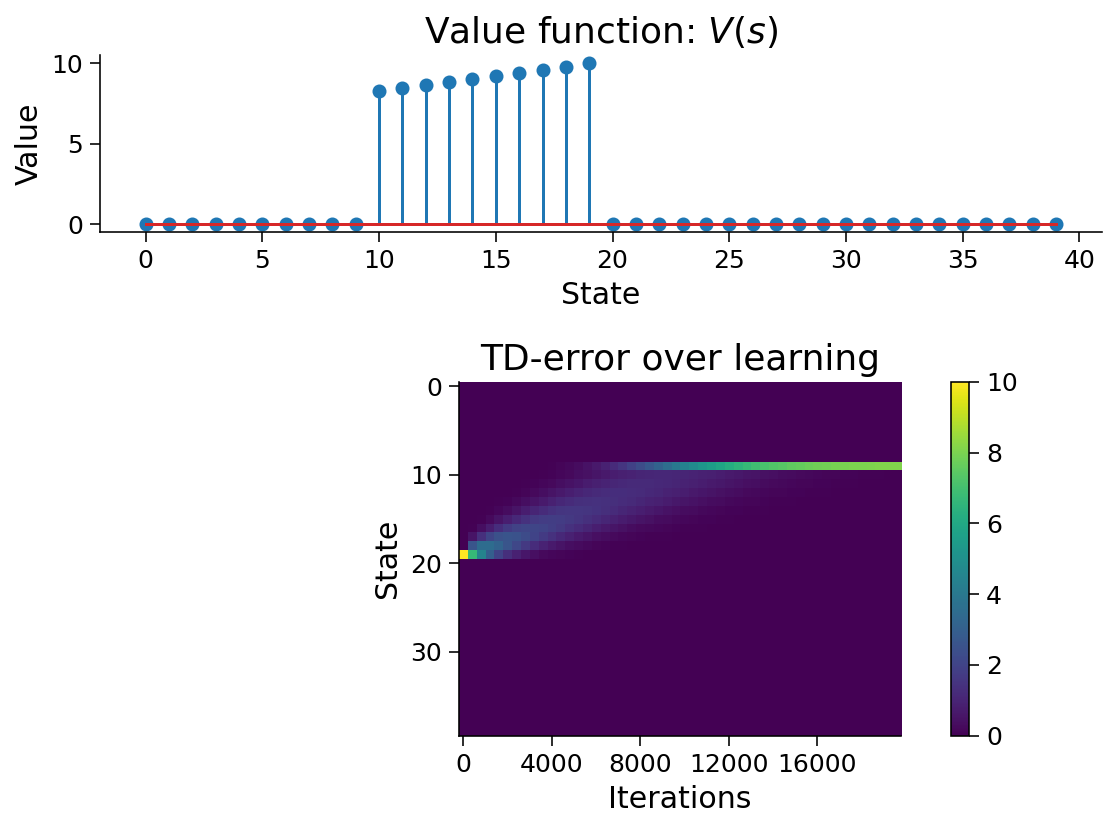

In [8]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact
def plot_summary_alpha_gamma(alpha = widgets.FloatSlider(value=0.0001, min=0.001, max=0.1, step=0.0001, description="alpha"),
                             gamma = widgets.FloatSlider(value=0.980, min=0, max=1.1, step=0.010, description="gamma")):
  env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10) 
  try:
    V_params, TDE_params = td_learner(env, n_trials=20000, gamma=gamma, alpha=alpha)
  except NotImplementedError:
    print("Finish Exercise 1 to enable this interactive demo")
  
  learning_summary_plot(V_params,TDE_params)



[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial1_Solution_12ce49be.py)



---
# Section 2: TD-learning with varying reward magnitudes

In the previous exercise, the environment was as simple as possible. On every trial, the CS predicted the same reward, at the same time, with 100% certainty. In the next few exercises, we will make the environment more progressively more complicated and examine the TD-learner's behavior. 


## Interactive Demo: Match the Value Functions

First, will replace the environment with one that dispenses multiple rewards. Shown below is the final value function $V$ for a TD learner that was trained in an enviroment where the CS predicted rewards of 6 or 14 units (both equally likely). Can you find another pair of rewards, both equally likely, that exactly match this value function? 

Hints:
* Carefully consider the definition of the value function $V$. This can be solved analytically.
* There is no need to change $\alpha$ or $\gamma$. 
* Due to the randomness, there may be a small amount of variation.

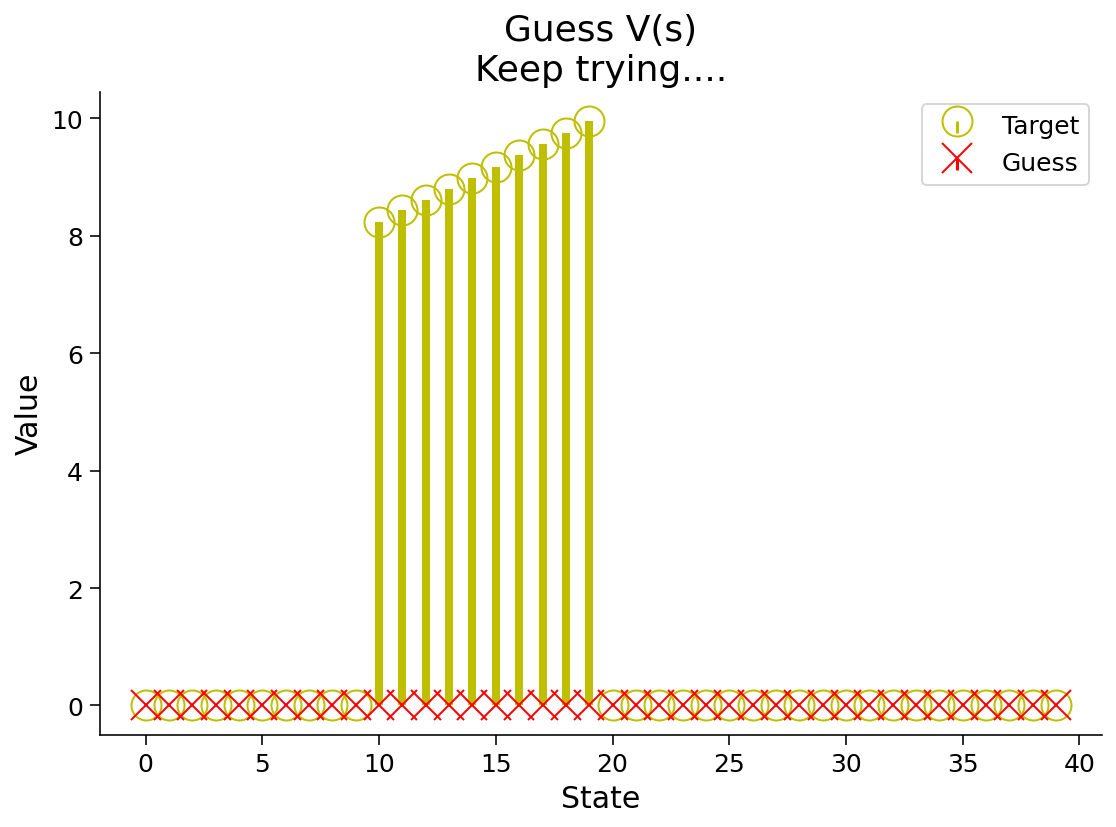

In [10]:
#@title 

#@markdown Make sure you execute this cell to enable the widget!

n_trials = 20000
rng_state = np.random.get_state()
env = MultiRewardCC(40, [6, 14], reward_time=10)
V_multi, TDE_multi = td_learner(env, n_trials, gamma=0.98, alpha=0.001)

@widgets.interact
def reward_guesser_interaction(r1 = widgets.IntText(value=0,  description="Reward 1"),
                               r2 = widgets.IntText(value=0, description="Reward 2")):                   
  try:
    env2 = MultiRewardCC(40, [r1, r2], reward_time=10)
    V_guess, _ = td_learner(env2, n_trials, gamma=0.98, alpha=0.001)
    fig, ax = plt.subplots()
    m, l, _ = ax.stem(V_multi, linefmt='y-', markerfmt='yo', basefmt=' ', label="Target", 
            use_line_collection=True)
    m.set_markersize(15)
    m.set_markerfacecolor('none')
    l.set_linewidth(4)
    m, _, _ = ax.stem(V_guess, linefmt='r', markerfmt='rx', basefmt=' ', label="Guess",
                      use_line_collection=True)
    m.set_markersize(15)

    ax.set_xlabel("State")
    ax.set_ylabel("Value")
    ax.set_title("Guess V(s)\n" + reward_guesser_title_hint(r1, r2))
    ax.legend()
  except NotImplementedError:
    print("Please finish Exercise 1 first!")

## Section 2.1 Examining the TD Error

Run the cell below to plot the TD errors from our multi-reward environment. A new feature appears in this plot? What is it? Why does it happen?

/opt/hostedtoolcache/Python/3.7.8/x64/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


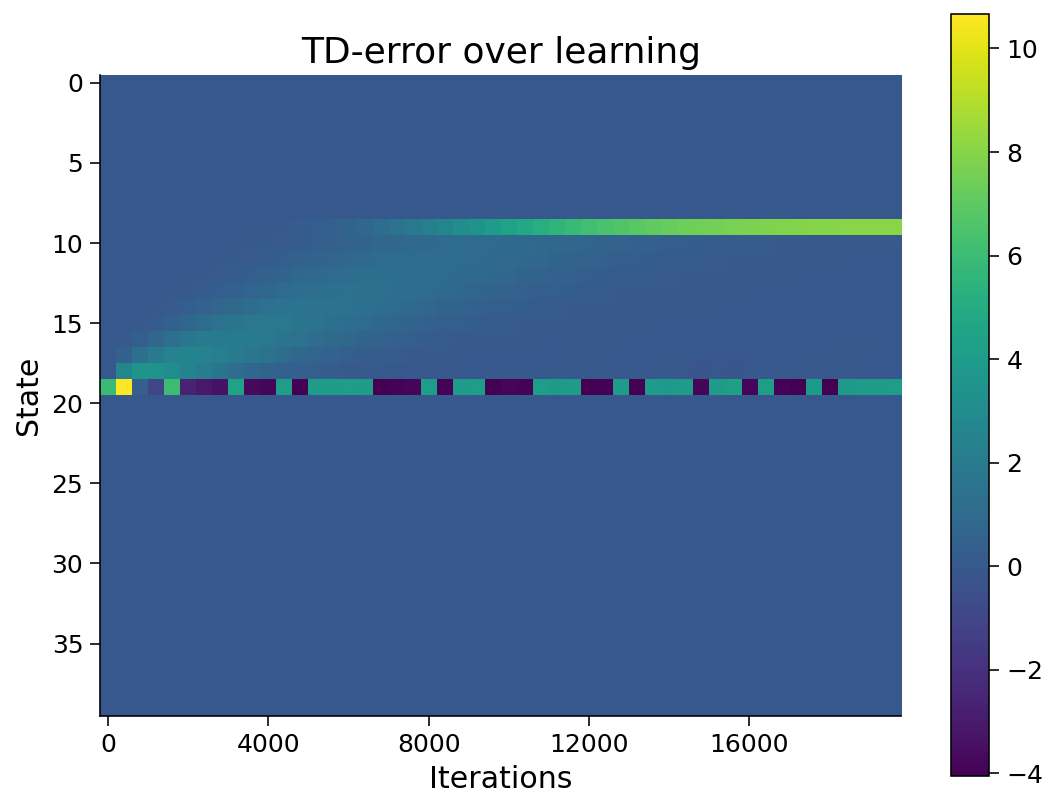

In [11]:
plot_tde_trace(TDE_multi)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial1_Solution_dea47c05.py)



---
# Section 3: TD-learning with probabilistic rewards

In this environment, we'll return to delivering a single reward of ten units. However, it will be delivered intermittently: on 20 percent of trials, the CS will be shown but the agent will not receive the usual reward; the remaining 80% will proceed as usual.

 Run the cell below to simulate. How does this compare with the previous experiment?

Earlier in the notebook, we saw that changing $\alpha$ had little effect on learning in a deterministic environment. What happens if you set it to an large value, like 1, in this noisier scenario? Does it seem like it will _ever_ converge?

/opt/hostedtoolcache/Python/3.7.8/x64/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


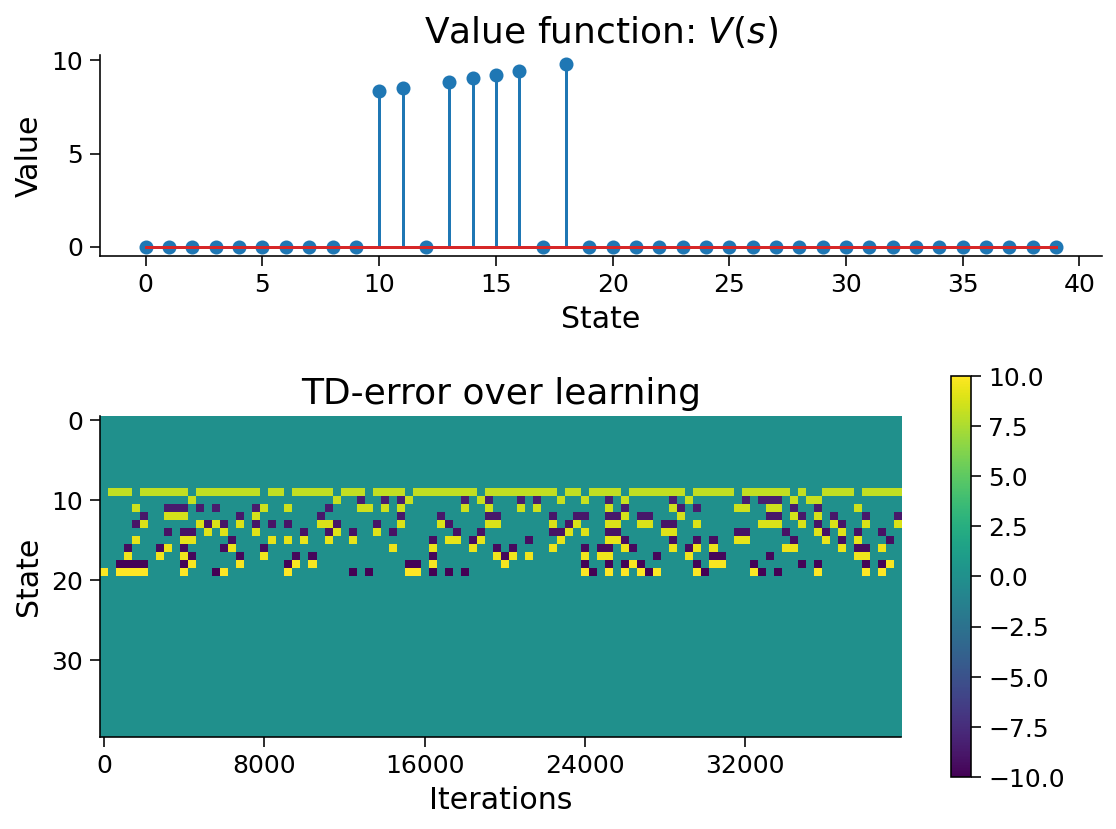

In [13]:
np.random.set_state(rng_state) # Resynchronize everyone's notebooks
n_trials = 20000
try:
  env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10, 
                        p_reward=0.8)
  V_stochastic, TDE_stochastic = td_learner(env, n_trials*2, alpha=1)
  learning_summary_plot(V_stochastic, TDE_stochastic)
except NotImplementedError: 
  print("Please finish Exercise 1 first")

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial1_Solution_7e8f30a0.py)



---
# Summary

In this notebook, we have developed a simple TD Learner and examined how its state representations and reward prediction errors evolve during training. By manipualting its environment and parameters ($\alpha$, $\gamma$), you developed an intuition for how it behaves.

This simple model closely resembles the behavior of subjects undergoing classical conditioning tasks and the dopamine neurons that may underlie that behavior. You may have implemented TD-reset or used the model to recreate a common experimental error. The update rule used here has been extensively studied for [more than 70 years](https://www.pnas.org/content/108/Supplement_3/15647) as a possible explanation for artificial and biological learning. 

However, you may have noticed that something is missing from this notebook. We carefully calculated the value of each state, but did not use it to actually do anything. Using values to plan _**Actions**_ is coming up next!

# Bonus

## Exercise 2: TD-reset 

In this exercise we will implement a commonly used heuristic used in modeling activity of dopamine neurons, TD-reset. 
Implement TD-learning as in previous exercises, but set TD-error to zero on all steps after reward (US). 

1. Plot value function and TD-errors. 
2. Can you explain how the reset is changing the TD-errors and value function?

In [15]:
def td_reset_learner(env, n_trials, alpha=0.25, gamma=0.98):
  """ Temporal Difference learning with the TD-reset update rule

  Args:
    env (object): the environment to be learned
    n_trials (int): the number of trials to run
    gamma (float): temporal discount factor
    alpha (float): learning rate
  
  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """
  V = np.zeros(env.n_steps)
  TDE_reset = np.zeros((env.n_steps, n_trials))

  for n in range(n_trials):
    state = 0
    reset = False
    
    for t in range(env.n_steps):
      next_state, reward = env.get_outcome(state)
      is_delay  = env.state_dict[state][0]
      
      ########################################################################
      ## TODO for students: implement TD learning with the TD-reset update rule
      # Fill out function and remove
      raise NotImplementedError("Student excercise: implement TD learning with the TD-reset update rule")
      ########################################################################
      # Write an expression to compute the TD-error using the TD-reset rule
      if reset:
        TDE_reset[state] = ...
      else:
        TDE_reset[state] = ...
      
      # Set reset flag if we receive a reward > 0
      if reward > 0:
        reset = True

      # Write an expression to update the value function
      V[state] += ...
      
      # Update state
      state = next_state

  return V, TDE_reset

# Uncomment these two lines to visualize your results
# env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10, 
#                       p_reward=0.8)
# V_reset, TDE_reset = td_reset_learner(env, n_trials=20000)
# learning_summary_plot(V_reset, TDE_reset)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial1_Solution_8259b30c.py)

*Example output:*

<img alt='Solution hint' align='left' width=558 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial1_Solution_8259b30c_1.png>



## Exercise 3: Removing the CS

In Exercise 1, you (should have) included a term that depends on the conditioned stimulus. Remove it and see what happens. Do you understand why?
This phenomena often fools people attempting to train animals--beware!

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D5_ReinforcementLearning/solutions/W2D5_Tutorial1_Solution_14d2fef0.py)

